<a href="https://colab.research.google.com/github/rymarinelli/Python/blob/master/Model_Inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning

In [1]:
%%capture
! wget https://s3.amazonaws.com/east1.public.rsna.org/AI/2017/Bone+Age+Training+Set.zip
! unzip /content/Bone+Age+Training+Set.zip
! wget https://www.rsna.org/-/media/Files/RSNA/Education/AI%20resources%20and%20training/AI%20image%20challenge/RSNA-2017-Pediatric-Bone-Age-Challenge-Dataset-Description.ashx?la=en&hash=A0B423007088816AFFACDCA934E2F09F903215F4&hash=A0B423007088816AFFACDCA934E2F09F903215F4
! wget https://s3.amazonaws.com/east1.public.rsna.org/AI/2017/Bone+Age+Training+Set+Annotations.zip
!unzip /content/Bone+Age+Training+Set+Annotations.zip

In [2]:
import pandas as pd
import os

# Load the CSV file into a pandas DataFrame
csv_file = 'train.csv'
df = pd.read_csv(csv_file)

# Directory containing the images
image_dir = 'boneage-training-dataset'

# Function to create file paths
def create_file_path(row):
    return os.path.join(image_dir, str(row['id']) + '.png')

# Apply the function to create file paths
df['file_path'] = df.apply(create_file_path, axis=1)

# Convert age to months (assuming it's already in months)
df['age_months'] = round(df['boneage']/30.25)

# Select only the required columns
df = df[['id', 'file_path', 'age_months']]

# Display the resulting DataFrame



In [3]:
import os

# Updated mapping from age_months to class IDs
age_to_class_id = {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6, 7.0: 7, 8.0: 8}

# Define the directory where the label files will be stored
label_dir = 'labels'
os.makedirs(label_dir, exist_ok=True)

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    image_id = row['id']
    age_months = row['age_months']

    # Convert age_months to class ID using the mapping
    class_id = age_to_class_id[age_months]

    # Create the label file content for YOLO: class_id, center_x, center_y, width, height
    label_content = f"{class_id} 0.5 0.5 1 1"

    # Define the label file path
    label_filename = f"{image_id}.txt"
    label_path = os.path.join(label_dir, label_filename)

    # Write the label file
    with open(label_path, 'w') as label_file:
        label_file.write(label_content)


In [4]:
import os
import shutil
import random

def move_files(source_dir, image_dest_dir, label_source_dir, label_dest_dir, percent=0.8):
    if not os.path.exists(image_dest_dir):
        os.makedirs(image_dest_dir)
    if not os.path.exists(label_dest_dir):
        os.makedirs(label_dest_dir)

    # List and filter .png files
    png_files = [f for f in os.listdir(source_dir) if f.endswith('.png') and f[:-4].isdigit()]
    number_to_move = int(len(png_files) * percent)
    png_files_to_move = random.sample(png_files, number_to_move)

    moved_numbers = set()
    for file_name in png_files_to_move:
        shutil.move(os.path.join(source_dir, file_name), os.path.join(image_dest_dir, file_name))
        moved_numbers.add(file_name[:-4])  # Capture the numeric part without '.png'

    # Move corresponding TXT files from common label source directory
    txt_files = [f for f in os.listdir(label_source_dir) if f.endswith('.txt') and f[:-4] in moved_numbers]
    for file_name in txt_files:
        shutil.move(os.path.join(label_source_dir, file_name), os.path.join(label_dest_dir, file_name))

# Define directories for images and labels
source_images = '/content/boneage-training-dataset'
label_source = '/content/labels'
train_images_dir = '/content/datasets/bone_age/train/images'
train_labels_dir = "/content/datasets/bone_age/train/labels"
val_images_dir = '/content/datasets/bone_age/val/images'
val_labels_dir = "/content/datasets/bone_age/val/labels"

# Move files for training
moved_train_numbers = move_files(source_images, train_images_dir, label_source, train_labels_dir, percent=0.8)

# Remaining PNG files for validation
remaining_png_files = [f for f in os.listdir(source_images) if f.endswith('.png') and f[:-4].isdigit()]
remaining_numbers = {f[:-4] for f in remaining_png_files}

# Move files for validation
move_files(source_images, val_images_dir, label_source, val_labels_dir, percent=1.0)  # Move all remaining files


In [5]:
%%writefile bone_age_dataset.yaml
train: /content/datasets/bone_age/train/images
val: /content/datasets/bone_age/val/images   # Adjust this path
nc: 9  # Number of classes
names: ['age_0_months', 'age_1_month', 'age_2_months', 'age_3_months', 'age_4_months', 'age_5_months', 'age_6_months', 'age_7_months', 'age_8_months']

Writing bone_age_dataset.yaml


# Detection Model

In [6]:
#!wget https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml
!git clone https://github.com/ultralytics/yolov5.git


Cloning into 'yolov5'...
remote: Enumerating objects: 16554, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 16554 (delta 16), reused 4 (delta 0), pack-reused 16522
Receiving objects: 100% (16554/16554), 15.08 MiB | 27.04 MiB/s, done.
Resolving deltas: 100% (11373/11373), done.


In [7]:
!pip install  ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [8]:

# Load YOLOv8n, train it on COCO128 for 3 epochs and predict an image with it
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # load a pretrained YOLOv8n detection model
#model.train(data='/content/yolov5/data/coco128.yaml', epochs=3)  # train the model
model.train(data='/content/bone_age_dataset.yaml', epochs=3)

100%|██████████| 6.23M/6.23M [00:00<00:00, 84.0MB/s]


Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/bone_age_dataset.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/bone_age/train/labels... 10088 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10088/10088 [00:16<00:00, 621.22it/s]


train: New cache created: /content/datasets/bone_age/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/bone_age/val/labels... 2523 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2523/2523 [00:04<00:00, 626.18it/s]


val: New cache created: /content/datasets/bone_age/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G     0.2282      2.002     0.9886         30        640: 100%|██████████| 631/631 [46:13<00:00,  4.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [04:40<00:00,  3.55s/it]


                   all       2523       2523      0.386      0.655      0.375       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G     0.1226      1.293      0.906         23        640: 100%|██████████| 631/631 [45:20<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [04:54<00:00,  3.73s/it]

                   all       2523       2523      0.613      0.625      0.499      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G    0.09171      1.142     0.8917         23        640: 100%|██████████| 631/631 [46:48<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [05:26<00:00,  4.13s/it]

                   all       2523       2523       0.65      0.619       0.51      0.503



3 epochs completed in 2.559 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3007403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [04:12<00:00,  3.20s/it]


                   all       2523       2523       0.65      0.619       0.51      0.503
          age_0_months       2523          7          1          0     0.0618      0.058
           age_1_month       2523         96      0.548      0.969      0.598       0.58
          age_2_months       2523        196      0.518      0.783      0.656      0.654
          age_3_months       2523        370      0.597      0.738       0.65      0.645
          age_4_months       2523        640      0.511      0.795       0.58      0.576
          age_5_months       2523        800      0.592      0.901      0.676      0.674
          age_6_months       2523        352      0.668      0.616      0.731      0.728
          age_7_months       2523         60      0.418      0.767      0.514       0.51
          age_8_months       2523          2          1          0      0.124      0.106
Speed: 1.1ms preprocess, 60.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detec

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e268ee3c640>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

In [ ]:
#results = model.predict(source="https://ultralytics.com/images/bus.jpg", line_width=1, show_conf=False, save=True)

#boxes = results[0].boxes.xywh.cpu()                        #xywh bbox list
#clss = results[0].boxes.cls.cpu().tolist()                 #classes Id list
#names = results[0].names                                   #classes names list
#confs = results[0].boxes.conf.float().cpu().tolist()       #probabilities of classes

#for box, cls, conf in zip(boxes, clss, confs):
#    x, y, w, h = box
#    label = str(names[cls] + " "+ str(conf))
#    x1, y1, x2, y2 = x-w/2, y-h/2, x+w/2, y+h/2

#print(names)
#print(confs)

In [ ]:
#def GetClassIndex(dict, value:str):
#  return [key for key, val in dict.items() if val == value]

#def GetConfidence(names:dict, confs:dict, value:str):
#  index = GetClassIndex(names, value)[0]
#  return confs[index]

#print(GetConfidence(names, confs, "person" ))

# Generating Data with GAN

In [9]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')  # Convert to RGB to handle grayscale images too

        if self.transform:
            image = self.transform(image)

        return image

# Example usage
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a fixed size (modify as needed)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

dataset = CustomImageDataset(image_dir='/content/datasets/bone_age/val/images', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example usage
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a fixed size (modify as needed)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

dataset = CustomImageDataset(image_dir='/content/datasets/bone_age/val/images', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [12]:
import torch
from torch import nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input is Z, going into a convolution
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            # Output is a 64 x 64 image
            nn.Linear(1024, 3*64*64),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input).view(-1, 3, 64, 64)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3*64*64, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        input = input.view(-1, 3*64*64)
        return self.model(input)


In [13]:
# Initialize models
generator = Generator()
discriminator = Discriminator()

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [14]:
num_epochs = 100
latent_size = 100  # Size of the latent noise vector

for epoch in range(num_epochs):
    for i, images in enumerate(dataloader):
        # Get real images
        real_images = images
        real_labels = torch.ones(images.size(0), 1)
        fake_labels = torch.zeros(images.size(0), 1)

        # Train Discriminator with real images
        optimizerD.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        # Train Discriminator with fake images
        noise = torch.randn(images.size(0), latent_size)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())  # Detach to avoid training G on these labels
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        optimizerD.step()

        # Train Generator
        optimizerG.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)  # Trick the discriminator
        g_loss.backward()
        optimizerG.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss_real.item() + d_loss_fake.item():.4f}, g_loss: {g_loss.item():.4f}')


Epoch [1/100], d_loss: 1.0864, g_loss: 1.1874
Epoch [2/100], d_loss: 1.1965, g_loss: 0.6564
Epoch [3/100], d_loss: 0.6671, g_loss: 0.8877
Epoch [4/100], d_loss: 1.0202, g_loss: 0.7055
Epoch [5/100], d_loss: 0.3825, g_loss: 1.3239
Epoch [6/100], d_loss: 0.8361, g_loss: 1.2616
Epoch [7/100], d_loss: 0.5569, g_loss: 0.8712
Epoch [8/100], d_loss: 0.8521, g_loss: 0.6880
Epoch [9/100], d_loss: 0.8810, g_loss: 1.2076
Epoch [10/100], d_loss: 0.8011, g_loss: 1.5254
Epoch [11/100], d_loss: 0.7213, g_loss: 1.2587
Epoch [12/100], d_loss: 0.9678, g_loss: 1.1466
Epoch [13/100], d_loss: 1.3894, g_loss: 0.9560
Epoch [14/100], d_loss: 1.1577, g_loss: 1.1670
Epoch [15/100], d_loss: 1.5565, g_loss: 1.3091
Epoch [16/100], d_loss: 1.2266, g_loss: 0.7287
Epoch [17/100], d_loss: 1.1454, g_loss: 0.9007
Epoch [18/100], d_loss: 1.2008, g_loss: 1.0533
Epoch [19/100], d_loss: 1.3400, g_loss: 0.8005
Epoch [20/100], d_loss: 1.1165, g_loss: 1.2869
Epoch [21/100], d_loss: 1.2772, g_loss: 0.7869
Epoch [22/100], d_loss

In [15]:
with torch.no_grad():
    fixed_noise = torch.randn(16, latent_size)  # Create a fixed noise vector
    fake_images = generator(fixed_noise)
    # Visualize or save generated images


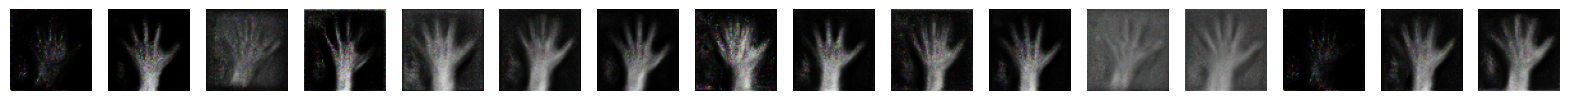

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming fake_images is a batch of images with shape [batch_size, channels, height, width]
# and the pixel values are normalized between -1 and 1

# Convert images to numpy and rescale values from [-1, 1] to [0, 1]
images_np = fake_images.cpu().detach().numpy()
images_np = (images_np + 1) / 2
images_np = np.transpose(images_np, (0, 2, 3, 1))  # Reorder dimensions to [batch_size, height, width, channels]

# Plot images
fig, axs = plt.subplots(nrows=1, ncols=len(images_np), figsize=(20, 2))
for i, ax in enumerate(axs.flat):
    if images_np.shape[-1] == 1:  # If grayscale, remove the color dimension
        ax.imshow(images_np[i].squeeze(), cmap='gray')
    else:
        ax.imshow(images_np[i])
    ax.axis('off')  # Remove axes
plt.show()


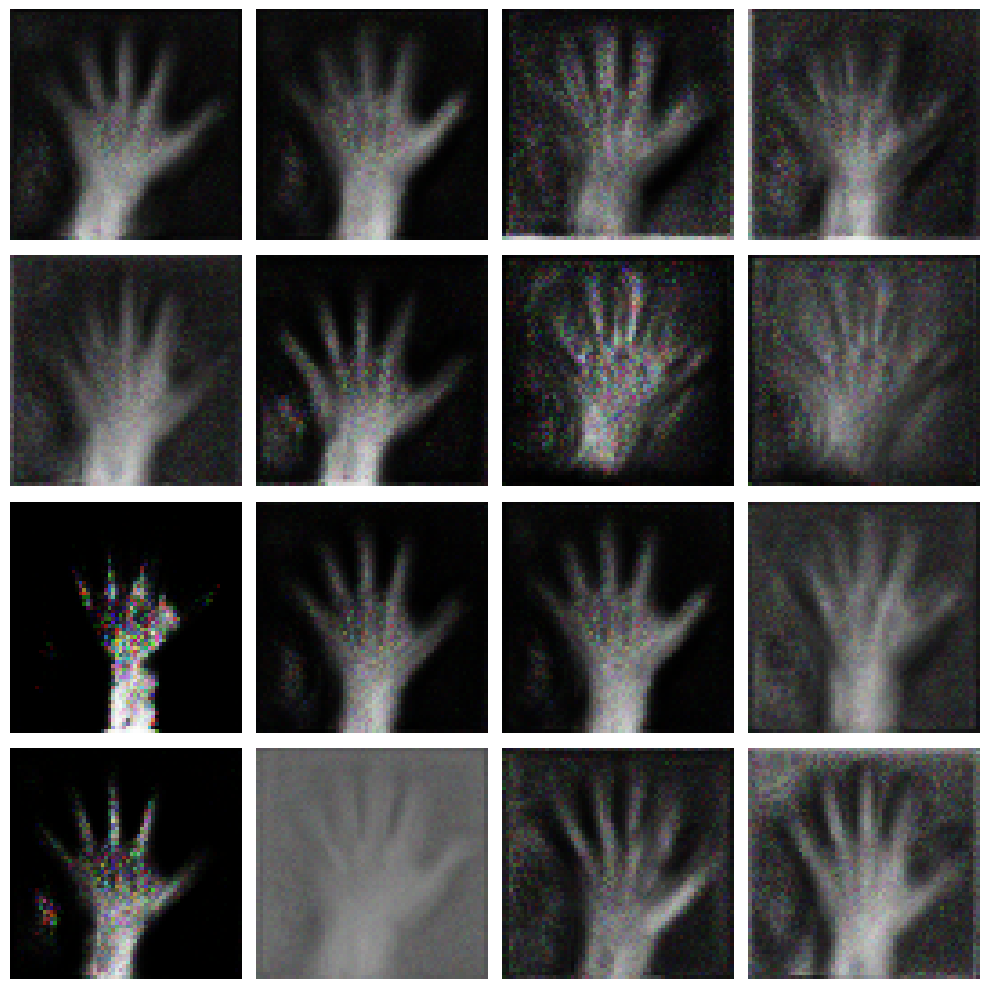

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a trained generator model and a latent_size defined
latent_size = 100  # Example latent size

with torch.no_grad():
    fixed_noise = torch.randn(16, latent_size)  # Create a fixed noise vector
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
        generator = generator.cuda()
    fake_images = generator(fixed_noise)  # Generate images from the noise

# Assuming fake_images is a batch of images with shape [batch_size, channels, height, width]
# and the pixel values are normalized between -1 and 1

# Convert images to numpy and rescale values from [-1, 1] to [0, 1]
images_np = fake_images.cpu().detach().numpy()  # Ensure tensor is moved to cpu before conversion
images_np = (images_np + 1) / 2  # Rescale pixel values
images_np = np.transpose(images_np, (0, 2, 3, 1))  # Reorder dimensions to [batch_size, height, width, channels]

# Plot images
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))  # Adjust for a square layout
for i, ax in enumerate(axs.flat):
    img = images_np[i]
    if img.shape[-1] == 1:  # If grayscale, remove the color dimension
        ax.imshow(img.squeeze(), cmap='gray')
    else:
        ax.imshow(img)
    ax.axis('off')  # Remove axes

plt.tight_layout()
plt.show()
